In [1]:
import pandas as pd
import numpy as np

from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
df = pd.read_pickle('processed_data/SARIMA_model_data')
print(df.shape)

n = df.shape[0]

(35064, 40)


In [3]:
df.head(10)

,Load1,Temp1,Load2,Temp2,Load3,Temp3,Load4,Temp4,Load5,Temp5,...,Load16,Temp16,Load17,Temp17,Load18,Temp18,Load19,Temp19,Load20,Temp20
0,16853.0,38.0,126259.0,42.0,136233.0,42.0,484.0,42.0,6829.0,42.0,...,28752.0,42.0,30645.0,42.0,200946.0,42.0,82298.0,45.0,79830.0,42.0
1,16450.0,36.0,123313.0,42.0,133055.0,42.0,457.0,42.0,6596.0,42.0,...,27851.0,42.0,30461.0,42.0,195835.0,42.0,79827.0,43.0,77429.0,42.0
2,16517.0,35.0,119192.0,40.0,128608.0,40.0,450.0,40.0,6525.0,40.0,...,27631.0,40.0,30197.0,40.0,194093.0,40.0,77728.0,41.0,75558.0,40.0
3,16873.0,30.0,117507.0,39.0,126791.0,39.0,448.0,39.0,6654.0,39.0,...,27986.0,39.0,30264.0,39.0,194708.0,39.0,76433.0,37.0,75709.0,39.0
4,17064.0,30.0,118343.0,40.0,127692.0,40.0,444.0,40.0,6977.0,40.0,...,29160.0,40.0,30907.0,40.0,202458.0,40.0,78172.0,33.0,77475.0,40.0
5,17727.0,29.0,121228.0,41.0,130805.0,41.0,490.0,41.0,7330.0,41.0,...,29226.0,41.0,31617.0,41.0,206923.0,41.0,77871.0,32.0,77854.0,41.0
6,18574.0,28.0,126731.0,38.0,136743.0,38.0,523.0,38.0,7795.0,38.0,...,31411.0,38.0,33220.0,38.0,219789.0,38.0,82895.0,30.0,82571.0,38.0
7,19355.0,28.0,132289.0,33.0,142741.0,33.0,581.0,33.0,8303.0,33.0,...,33447.0,33.0,34531.0,33.0,230457.0,33.0,87599.0,29.0,85996.0,33.0
8,19534.0,28.0,139941.0,36.0,150997.0,36.0,612.0,36.0,9190.0,36.0,...,34591.0,36.0,34837.0,36.0,240851.0,36.0,90546.0,30.0,91065.0,36.0
9,18611.0,33.0,141950.0,43.0,153165.0,43.0,633.0,43.0,9516.0,43.0,...,33637.0,43.0,33418.0,43.0,243584.0,43.0,86826.0,41.0,94689.0,43.0


## Adding Exogenous temperature data

In [4]:
# FOR DEVELOPMENT PURPOSES ONLY: So things don't take so long to run...
cut_beginning = 20000

endog = df.Load1[cut_beginning:]
exog = df.Temp1[cut_beginning:]

# Holds this data out
num_test = 10*24

In [5]:
model = SARIMAX(endog=endog[:-num_test], exog=exog[:-num_test], order=(2,0,1), seasonal_order=(1,0,0,24))
fit_res = model.fit(disp=False, maxiter=25)
print(fit_res.summary())

/Users/matthewjohnson/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                      
Dep. Variable:                               Load1   No. Observations:                14824
Model:             SARIMAX(2, 0, 1)x(1, 0, [], 24)   Log Likelihood             -121322.425
Date:                             Thu, 12 May 2022   AIC                         242656.850
Time:                                     13:08:27   BIC                         242702.474
Sample:                                          0   HQIC                        242671.996
                                           - 14824                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Temp1        166.5125      3.996     41.672      0.000     158.681     174.344
ar.L1          1.9238      

In [6]:
# Use full dataset
mod = sm.tsa.statespace.SARIMAX(endog=endog, exog=exog, order=(2,0,1), seasonal_order=(1,0,0,24))

# But use estimated parameters
res = mod.filter(fit_res.params)

In [7]:
# In-sample one-step-ahead predictions
predict = res.get_prediction()
predict_ci = predict.conf_int()

In [8]:
# Dynamic predictions
predict_dy = res.get_prediction(dynamic=endog.shape[0]-num_test)
predict_dy_ci = predict_dy.conf_int()

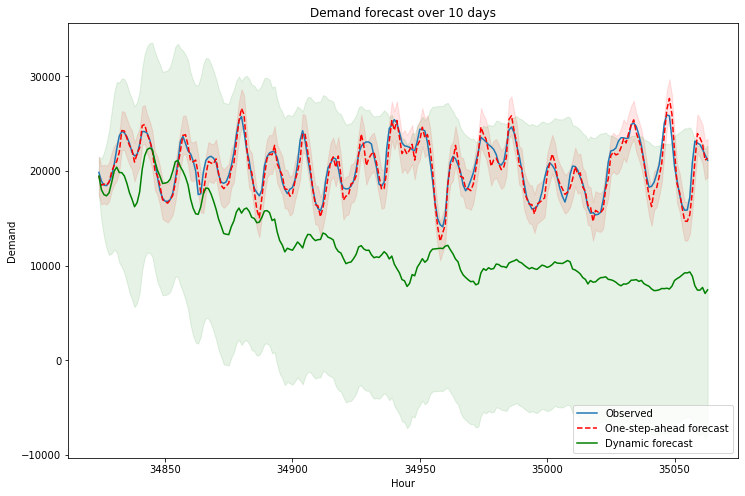

In [9]:
# Graph
fig, ax = plt.subplots(figsize=(12,8))
npre = 4
ax.set(title='Demand forecast over 10 days', xlabel='Hour', ylabel='Demand')

# Plot data points
endog[-num_test:].plot(ax=ax, style='-', label='Observed')

# Plot predictions
predict.predicted_mean[-num_test:].plot(ax=ax, style='r--', label='One-step-ahead forecast')
ci = predict_ci[-num_test:]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)
predict_dy.predicted_mean[-num_test:].plot(ax=ax, style='g', label='Dynamic forecast')
ci = predict_dy_ci[-num_test:]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='g', alpha=0.1)

legend = ax.legend(loc='lower right')

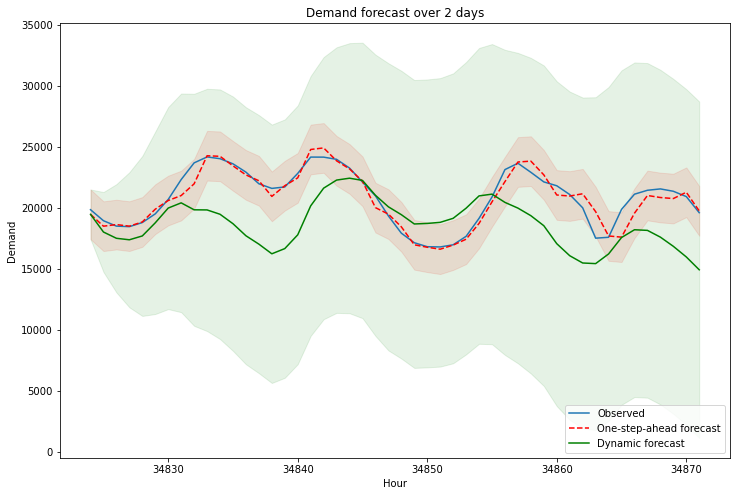

In [10]:
# Plot the beginning portion of the graph above
PLOT_BEGIN_DAYS = 2

# Graph
fig, ax = plt.subplots(figsize=(12,8))
npre = 4
ax.set(title='Demand forecast over '+str(PLOT_BEGIN_DAYS)+' days', xlabel='Hour', ylabel='Demand')

# Plot data points
endog[-num_test:-num_test + PLOT_BEGIN_DAYS*24].plot(ax=ax, style='-', label='Observed')

# Plot predictions
predict.predicted_mean[-num_test:-num_test+PLOT_BEGIN_DAYS*24].plot(ax=ax, style='r--', label='One-step-ahead forecast')
ci = predict_ci[-num_test:-num_test+PLOT_BEGIN_DAYS*24]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)
predict_dy.predicted_mean[-num_test:-num_test+PLOT_BEGIN_DAYS*24].plot(ax=ax, style='g', label='Dynamic forecast')
ci = predict_dy_ci[-num_test:-num_test+PLOT_BEGIN_DAYS*24]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='g', alpha=0.1)

legend = ax.legend(loc='lower right')